# 1.加载数据（TIDB）

In [4]:
import pandas as pd
from sqlalchemy import create_engine

# 数据库连接设置，请根据您的实际数据库类型和配置进行修改
database_type = 'mysql'  # 或 'postgresql', 'sqlite', 等
username = '4JHciBfpftZR67E.root'  # 数据库用户名
password = 'aidBsAjcm2YUaFac'  # 数据库密码
host = 'gateway01.us-west-2.prod.aws.tidbcloud.com'  # 数据库主机地址
port = '4000'  # 数据库端口
database_name = 'django'  # 数据库名称

# 创建数据库引擎
engine = create_engine(f'{database_type}://{username}:{password}@{host}:{port}/{database_name}')

# 读取数据到DataFrame中
# 假设数据库中的表名与Excel文件中的数据结构相同
table_name = 'data_nonmainland'  # 数据库中的表名
query = f'SELECT * FROM {table_name}'

# 使用pandas的read_sql_query函数读取数据
dataframe = pd.read_sql_query(query, engine)

# 显示前几行数据以确认
print(dataframe.head())


           日期      合计     外国人     港澳    台湾省
0  2015-01-01  586538  359356  32461  51225
1  2015-02-01  442199  255894  28672  32098
2  2015-03-01  758521  484457  42057  62269
3  2015-04-01  757013  498421  47158  59697
4  2015-05-01  736034  506426  43845  63952


2.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 数据标准化
scr = MinMaxScaler()
std = scr.fit_transform(inp)
# 输入数据规范化
train_x, train_y = [], []
for i in range(TIME_STEP, std.shape[0] - PRED_STEP + 1):
    train_x.append(std[i - TIME_STEP:i])
    train_y.append(std[i])
train_x, train_y = np.array(train_x), np.array(train_y)

In [ ]:
from matplotlib import pyplot as plt


def loss(information_loss):
    plt.figure(figsize=(12, 8))
    plt.plot(information_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
import tensorflow as tf
from keras import datasets, layers, optimizers, Sequential, metrics

# 构建全局网络，包含卷积层，池化层，双向LSTM层
network = Sequential([
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, activation='sigmoid'),
                         input_shape=(TIME_STEP, DATA_SCALE)),
    layers.Flatten(),
    layers.Dense(DATA_SCALE, activation='sigmoid')
])
# 查看网络结构
network.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 4, 64)            9216      
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 9,987
Trainable params: 9,987
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
94/94 [==============================] - 2s 2ms/step - loss: 0.6245 - accuracy: 0.6170
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5372 - accuracy: 0.7021
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5342 - accuracy: 0.7128
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5257 - accuracy: 0.6702
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.7553
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5248 - accuracy: 0.7234
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5239 - accuracy: 0.7234
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5380 - accuracy: 0.6596
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5300 - accuracy: 0.7447
Epoch 10/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.7021
Epoch 11/

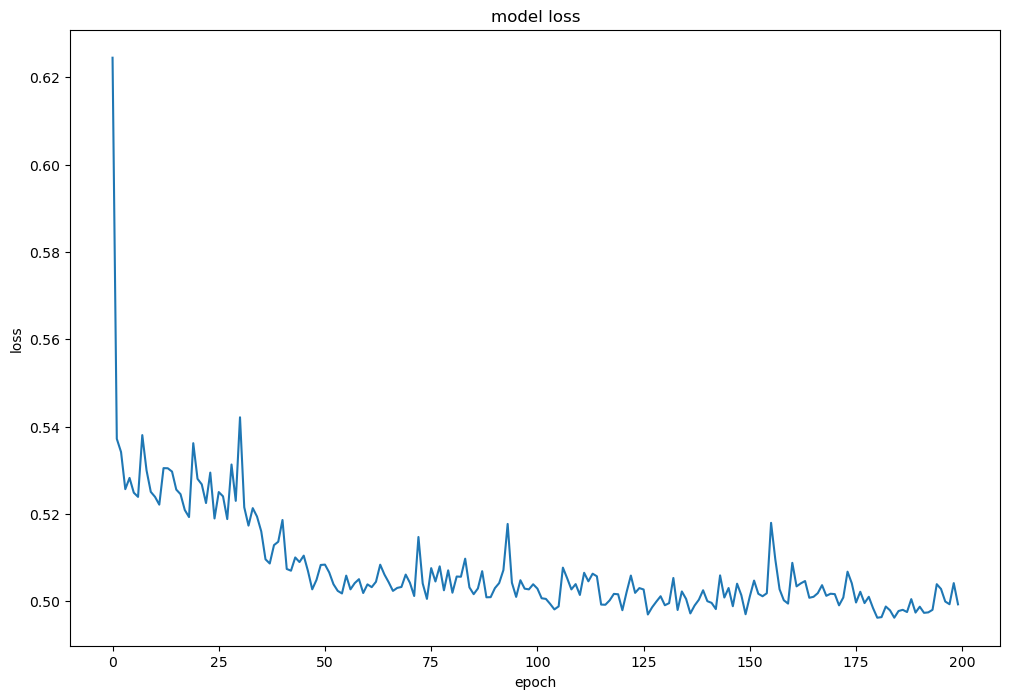

In [ ]:
# 编译网络
network.compile(optimizer=optimizers.Adam(learning_rate=0.1),
                loss=tf.losses.binary_crossentropy,
                metrics=['accuracy']
                )
# 训练网络
model_information = network.fit(train_x, train_y, epochs=200, batch_size=1)
# 模型损失可视化
information_loss = model_information.history['loss']  # 模型训练损失
loss(information_loss)

In [ ]:
# save and evaluate
network.save('../models/nmainland_pred.h5')
flag = network.evaluate(train_x, train_y, verbose=0)
print(f'loss:{flag[0]}\nacc:{flag[1]}')

loss:0.4966869056224823
acc:0.7234042286872864


In [ ]:
# 检查模型可用性
import keras

new_network = keras.models.load_model('../models/nmainland_pred.h5')

In [ ]:
# 单步多次预测
out = []
step = std[-TIME_STEP:]
for _ in range(PRED_LENGTH):
    tmp = new_network.predict(step.reshape(-1, TIME_STEP, DATA_SCALE))
    step = np.append(step, tmp, axis=0)
    step = np.delete(step, 0, 0)
    out.append(scr.inverse_transform(tmp).reshape(DATA_SCALE))
out = np.array(out).astype(int)

1/1 [==============================] - 0s 18ms/step


In [ ]:
# 将数据重塑为数据库所能接受的，并转为csv，放入数据库
from dateutil.relativedelta import relativedelta
import datetime

# 生成时间轴
START_TIME = datetime.datetime.strptime('2023-03-01', '%Y-%m-%d')
timeline = [(START_TIME + relativedelta(months=i)).strftime('%Y-%m-%d') for i in range(PRED_LENGTH)]
timeline = np.array(timeline).reshape(PRED_LENGTH, -1)

# 生成合计项
val = np.sum(out, axis=1).astype(int).reshape(PRED_LENGTH, -1)
tmp = np.concatenate([timeline, val, out], axis=1)
res = pd.DataFrame(tmp, columns=["日期", "合计", "外国人", "港澳", "台湾省"])

# 合并成一个dataframe
res

,日期,合计,外国人,港澳,台湾省
0,2023-03-01,23077,11974,3784,7319
1,2023-04-01,43360,23107,6318,13935
2,2023-05-01,70971,39212,9053,22706
3,2023-06-01,74245,47191,10468,16586
4,2023-07-01,85752,50487,13876,21389
5,2023-08-01,123483,76987,17458,29038
6,2023-09-01,105912,63206,17071,25635
7,2023-10-01,147385,98662,18517,30206
8,2023-11-01,106726,59470,19396,27860
9,2023-12-01,129067,87364,15902,25801


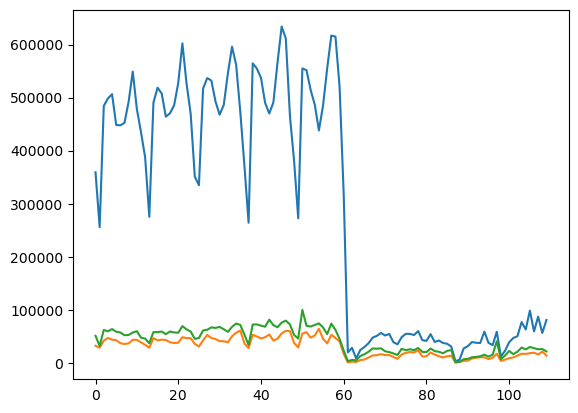

In [ ]:
# 画图
all = np.append(inp, out, axis=0)
length, size = all.shape
plt.plot(all)